# Symbolic Regression through Genetic Programming 
## Importing relevant packages

In [2]:
!pip install deap

     |████████████████████████████████| 160 kB 5.0 MB/s 


In [3]:
import math, random, operator
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from deap import algorithms, base, creator, tools, gp

## Data Prep
### Pulling Data In

In [4]:
data1 = pd.read_csv("data1.csv")
data2 = pd.read_csv("data2.csv")

### Splitting Data

In [5]:
train1, test1 = train_test_split(data1, test_size=0.2, shuffle=True)
train2, test2 = train_test_split(data2, test_size=0.2, shuffle=True)

## Defining Operations

In [6]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
def create_pset(data_set):
    rand_integer = random.randint(1,1234238)
    eph_name = "rand1_" + str(rand_integer) 
    n_var = len(data_set.columns) - 1
    pset = gp.PrimitiveSet("MAIN", n_var)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)    
    pset.addEphemeralConstant(eph_name, lambda: random.randint(-1,1))
    return pset

## Fitness Function

In [7]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    y_set = points['y'].to_numpy()
    x_set = points[points.columns.difference(['y'])].to_numpy()

    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(*x.tolist()) - y)**2 for x,y in zip(x_set, y_set))
    return math.fsum(sqerrors) / len(points),

## GP Execution Functions

In [ ]:
def run_GP(data, population, num_gen, mut, xover):
    ## Fitness function
    pset = create_pset(data)
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    toolbox.register("evaluate", evalSymbReg, points = data)

    #deap.tools.selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr='fitness')
    #toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.4, fitness_first=False)

    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

    pop = toolbox.population(n=population)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    #mstats.register("std", np.std)
    mstats.register("min", np.min)
    #mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, xover, mut, num_gen, stats=mstats,
                                   halloffame=hof, verbose=True)
    return pop, log, hof

In [8]:
pset = create_pset(train2)
## Fitness function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg, points = train2)

#deap.tools.selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr='fitness')
#toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.4, fitness_first=False)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
#mstats.register("std", np.std)
mstats.register("min", np.min)
#mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 2000, stats=mstats,
                               halloffame=hof, verbose=True)
# print log

   	      	                   fitness                    	             size             
   	      	----------------------------------------------	------------------------------
gen	nevals	avg        	gen	min      	nevals	avg    	gen	min	nevals
0  	300   	1.69327e+13	0  	0.0118373	300   	3.35667	0  	2  	300   
1  	247   	7.43133e+11	1  	0.0118373	247   	2.96667	1  	1  	247   
2  	237   	2.63809e+13	2  	0.0118373	237   	2.84667	2  	1  	237   
3  	249   	1.32365e+13	3  	0.0118373	249   	2.67667	3  	1  	249   
4  	259   	6.90334e+09	4  	0.0118373	259   	2.47   	4  	1  	259   
5  	236   	1.28903e+13	5  	0.0118373	236   	2.46667	5  	1  	236   
6  	236   	1.1996e+13 	6  	0.00451904	236   	2.45333	6  	1  	236   
7  	245   	6.90297e+09	7  	0.00451904	245   	2.33333	7  	1  	245   
8  	241   	878871     	8  	0.00451904	241   	2.20667	8  	1  	241   
9  	237   	627825     	9  	0.0202534 	237   	2.13667	9  	1  	237   
10 	247   	432730     	10 	0.0793676 	247   	2.18333	10 	1  	247   
11 	252   	3.

In [9]:
from sympy import sympify
import matplotlib.pyplot as plt
best_solution = hof.items[0]
operatorDict = {
    'sub': lambda x, y : x - y,
    'protectedDiv': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
}
expr = sympify(str(best_solution) , locals=operatorDict)
expr = str(expr).replace("neg", "-").replace("_list","_list[i]").replace('ARG0', 'x1').replace('**', '^').replace('ARG1', 'x2').replace('ARG2', 'x3')
expr

'cos(cos(x2/((-x2/cos(sin((-x1/cos(sin(1)) + x3 + sin(1))*sin(sin(1))*cos(1)/x2)) + x3 - cos(x3))*cos(1)))/sin(sin(sin(1))))'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


nan

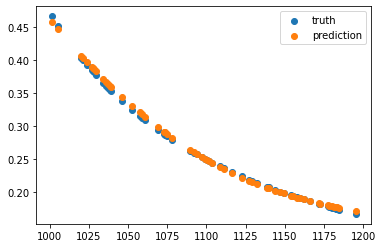

In [10]:
func = toolbox.compile(expr=best_solution)
y_set = test2['y'].to_numpy()
x_set = test2[test2.columns.difference(['y'])].to_numpy()
features = []
prediction = []
truth = []
# Evaluate the mean squared error between the expression
# and the real function : x**4 + x**3 + x**2 + x
for x,y in zip(x_set, y_set):
    features.append(x[0])
    prediction.append(func(*x.tolist()))
    truth.append(y)
plt.scatter(features, truth, label='truth')
plt.scatter(features, prediction, label='prediction')
plt.legend()
plt.show()


In [11]:
np_predict = np.array(prediction)
np_truth = np.array(truth)
np.sum((np_predict - np_truth)**2) / len(np_predict)

1.4037008285535804e-05